In [1]:
import RegTomoRecon as rtr
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt

## Import data and tilt series
In this example we simulate data from a simple blob phantom for demonstrative purposes. Here we use the axis ordering etc. which is default in astra. The following example gives a more practical overview.

In [2]:
from skimage.data import binary_blobs
# Simulate 2D 'blob' phantom
blobs = binary_blobs(length=128, n_dim=2, volume_fraction=0.1, seed=1)
# Make specimen thin in third dimension
groundtruth = np.concatenate([np.zeros((128,10,128)), np.tile(blobs.reshape(128,1,128), (1,10,1)), 
                         np.zeros((128,10,128))], axis=1).astype('f4')

# Simulate data with X-ray transform:
# Define tomography geometry
angles, detector = np.linspace(0, np.pi, 30), (128,128)
# create null data consistent with desired geometry
null_data = rtr.tomo_data(np.zeros((detector[0], len(angles), detector[1])), angles, degrees=False)
Xray3 = null_data.getOperator(vol_shape=groundtruth.shape, backend='astra')
volume, proj_geom = Xray3.vshape, Xray3.sshape
raw_data = (Xray3 * groundtruth.ravel()).reshape(proj_geom)

# Normalise data
raw_data -= raw_data.min()
raw_data /= raw_data.max()
# Create custom data object
data = rtr.tomo_data(raw_data, angles, degrees=False)

A more typical example would be to load data from files, as in the code below. This is then cast to a custom data-object, the syntax of which is:
- `stack_dim` dimension should be the same length as the number of projections 
- `tilt_axis` should be the dimension in which the scan is being performed slice-wise.
- `degrees` is a flag which allows switching from radians

After initialisation, `data` object will have shape equal to `(number of slices, width of detector, number of projections)`

In [3]:
# from skimage.io import imread
# angles = np.loadtxt('myangles.txt')
# raw_data = imread('mydata.tif').astype('float32')
# data = rtr.tomo_data(raw_data, angles, degrees=True,
#                     tilt_axis=1, stack_dim=0)

### Creating projector for reconstruction
`backend` and `GPU` are just default values so they could be left out.
Possible backends are `'astra'` or `'skimage'`. The volume shape can be chosen freely although each individual pixel of the detector will be physically 'square'. This allows us to control the thickness of the reconstruction.

In [4]:
# vol_shape = (n. slices, thickness, width of detector)
vol_shape = (data.shape[0],30,data.shape[2])
projector = data.getOperator(vol_shape=vol_shape, backend='astra', GPU=True)

## Various reconstructions
These algorithms are not well documented but should hopefully be self explanatory. I will try to list the most relevant parameters for each algorithm here.
### FBP
- `filter`: The filter used for inversion. The astra backend supports many filters, `'ram-lak'` is the default, see `help(fbp)` for more details. The skimage backend supports
    - ramp (default)
    - shepp-logan
    - cosine
    - hamming
    - hann
- `min_val`: The reconstruction will be thresholded at this level after the back-projection
- `max_val`: The reconstruction will be thresholded above this level after the back-projection

In [5]:
fbp = rtr.FBP(filter='Ram-Lak', min_val=0, max_val=None)
fbp_recon = fbp.run(data=data,op=projector)

### SIRT, only available with astra backend
- `iterations`: Number of iterations to perform, default is 100
- `min_val`: The reconstruction will be thresholded at this level after the back-projection
- `max_val`: The reconstruction will be thresholded above this level after the back-projection

In [6]:
sirt = rtr.SIRT()
sirt_recon = sirt.run(data=data,op=projector,iterations=10,
                      min_val=0,max_val=None)

### SART
- `iterations`: Number of iterations to perform, default is 100
- `min_val`: The reconstruction will be thresholded at this level after the back-projection
- `max_val`: The reconstruction will be thresholded above this level after the back-projection

In [7]:
sart = rtr.SART()
sart_recon = sart.run(data=data,op=projector,iterations=20,
                      min_val=0,max_val=None)

### TV
Implements a variational model of the form $\min_u \frac12|op\cdot u-data|_2^2 + weight*|\nabla u|_1$
- `order`: The order of derivative to use, i.e. `order=1` will result in piece-wise constant reconstructions and `order=2` corresponds to piece-wise linear or 'TV2' regularisation  
- `weight`: The weight of regularisation, `weight=1` will be over-smoothed and `weight=0` will be noisy.

In [8]:
alg = rtr.TV(vol_shape, order=1)

### TGV
Implements a variational model of the form $\min_{u,v} \frac12|op\cdot u-data|_2^2 + weight_1*|\nabla u - v|_1 + weight_2*|\nabla v|_1$
- `weight`: Similar to before. TGV requires two weights, the first on the first order gradient penalty and the second on the second order gradient. If only one weight is provided then it is assumed that they are equal. Again, a good range is between 0 and 1.

In [9]:
# alg = rtr.TGV(vol_shape)

### Performing iterative regularised reconstructions
All iterative reconstructions are performed using the primal-dual hybrid gradient method (see `help(rtr.PDHG)` for references). There are two parameters which should not effect the reconstruction but do effect speed of convergence.
- `balance`: This is technically the ratio between primal and dual step-sizes. The default is 1, somewhere between 0.1 and 10 is a resonable range. 
- `steps`: Either `None`, `'backtrack'` (default), or `'adaptive'`. `None` is standard but occassionally produced a chequerboard-like artefact in reconstructions due to some quirks of the astra toolbox. This should be fixed now but is definitely fixed by `'backtrack'`. `'Adaptive'` should find a good value of *balance* automatically, but defining the best value is very subjective. If you're happy in your choice of *balance*, then choosing `None` will be slightly faster than the other two methods.

The parameters for tracking and printing convergence metrics are:
- `callback`: A list of printouts to show over time, if it's `None` (default) then it will not print anything.  
- `callback_freq`: How often to print (and compute) the values, default is every 10 iterations.  

The values I have given below should be plenty to see if the algorithms have converged. 
- `primal` is the value of the function you are minimising, if it stops going down then you have minimised the function
- `gap` and `feasibility` are slightly better measures of how close you are to optimality, if both values are smaller than 1e-4 then the algorithm is probably converged.
- `step` (not to be confused with `steps`) measures how much your reconstruction is changing between iterations, this is also a proxy for a measure of the size of the gradient which should be going to 0. Again, if this goes below about 1e-4/1e-5 then the reconstruction has probably converged.

In [10]:
maxiter = 100
weight = 0.01
balance = 1
steps = 'adaptive'

recon = alg.run(data=data,op=projector, maxiter=maxiter, weight=weight,
                balance=balance, steps=steps,
                callback=('primal','gap','violation','step'))[0]

if steps=='adaptive':
    print('Optimal balance was: %.3f'% ((alg.s/alg.t)**.5))

 Iter   Time      primal          gap        violation       step     
   0%     0s     1.604e+03     1.000e+00          0        0.000e+00  
  10%     2s     9.240e+01    -5.316e-01     1.073e-01     2.176e-01  
  20%     4s     4.510e+01    -1.216e-02     3.827e-02     9.602e-02  
  30%     5s     4.148e+01    -8.843e-02     1.914e-02     4.130e-02  
  40%     7s     4.001e+01    -5.700e-02     1.135e-02     2.465e-02  
  50%     8s     3.926e+01    -4.507e-02     7.715e-03     1.615e-02  
  60%    10s     3.889e+01    -3.289e-02     6.229e-03     1.140e-02  
  70%    11s     3.869e+01    -2.339e-02     5.314e-03     8.244e-03  
  80%    13s     3.855e+01    -1.638e-02     4.542e-03     6.240e-03  
  90%    14s     3.846e+01    -1.150e-02     4.070e-03     4.993e-03  
 100%    16s     3.840e+01    -8.148e-03     3.734e-03     4.037e-03  

Optimal balance was: 1.050


## Plotting the reconstruction
The returned reconstruction is a standard numpy array and can be plotted or saved with standard tools. These plots are more to give a flavour of which coordinate axes of the reconstruction correspond to the frame of reference of the original data.

<IPython.core.display.Javascript object>


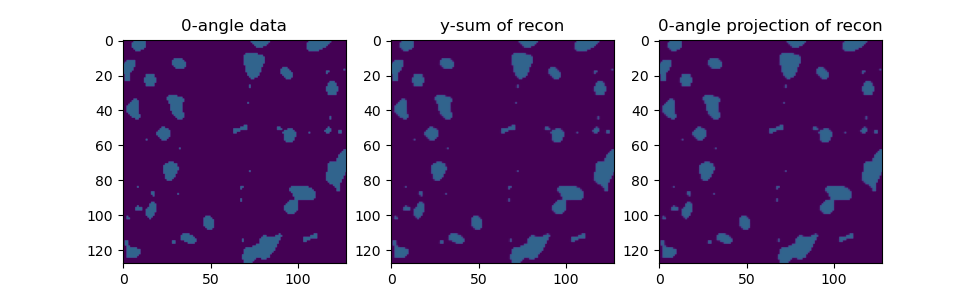

In [11]:
plt.figure(figsize=(9.8,3)); params = {'vmin':data.min(), 'vmax':data.max(), 'aspect':'equal'}
plt.subplot(131)
plt.imshow(data[:,abs(angles).argmin()], **params)
plt.title('0-angle data')
plt.subplot(132)
plt.imshow(recon.sum(1), **params)
plt.title('y-sum of recon')
plt.subplot(133)
plt.imshow((projector*recon.reshape(-1)).reshape(data.shape)[:,abs(angles).argmin()], **params)
plt.title('0-angle projection of recon')
plt.show()

### Comparison with filtered back-projection

<IPython.core.display.Javascript object>


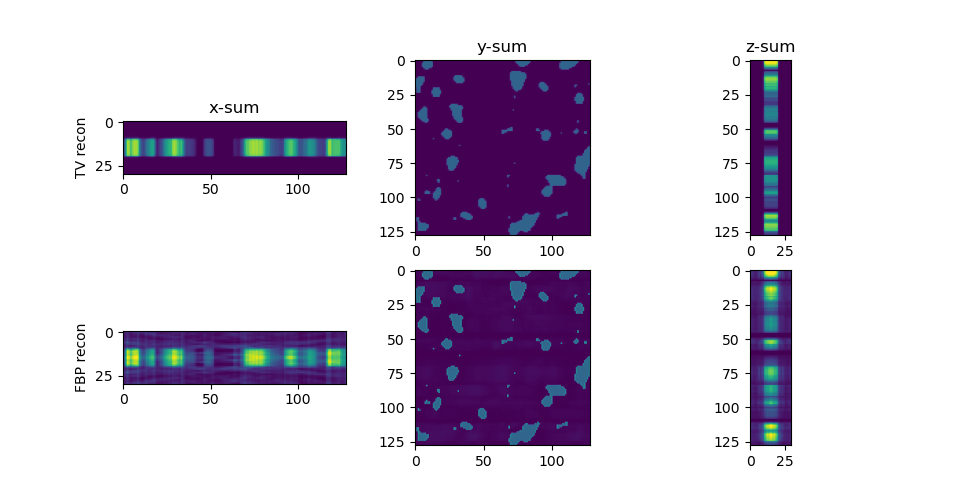

In [12]:
plt.figure(figsize=(9.8,5))
aspect='equal'
for i in range(3):
    plt.subplot(2,3,i+1)
    plt.imshow(recon.sum(i), vmin=0, vmax=1, aspect=aspect)
    if i==0:
        plt.ylabel('TV recon')
    plt.title('xyz'[i] + '-sum')
    plt.subplot(2,3,i+4)
    plt.imshow(fbp_recon.sum(i), vmin=0, vmax=1, aspect=aspect)
    if i==0:
        plt.ylabel('FBP recon')
plt.show()

## Saving output arrays

In [13]:
# recon.astype('float32').tofile('myfile.raw')